In [1]:
import apd_utils as apd
import numpy as np 
import pandas as pd
import random

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


## 1. Generate a referenced dataset and a random sample and perform DBSCAN
The initial step involves generating a referenced dataset and establishing a generic analytical workflow. To evaluate a sample, only five steps are necessary, as outlined below. It is important to note that in this case, a non-adulterated sample is generated, which means that the label predicted by DBSCAN for the sample should be identical to the labels of the referenced samples.

In [2]:
# 1. Generate a referenced dataset to represent authentic products
data_ref = apd.generate_ref_data(num_sample=50, num_analyte=200, seed=32)

# 2. Generate a non-adulterated random sample
sample_ref = apd.generate_random_sample(data_ref, adulterated=False, seed=64)

# 3. Combine referenced data and the random sample
data_comb = np.concatenate((data_ref, sample_ref), axis=0)

# 4. Scale the data  
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_comb)

# 5. Perform DBSCAN on scaled data
dbscan = DBSCAN(eps=20).fit(scaled_data)

print(f"Labels for referenced data: {dbscan.labels_[0:30]}")
print(f"Label for the non-adulterated sample: {dbscan.labels_[-1]}")

Labels for referenced data: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Label for the non-adulterated sample: 0


## 2. Generate some adulterated samples and perform DBSCAN 
In this case, we generated three adulterated samples with varying numbers of altered analytes in `num_analyte`. By default, each analyte concentration is reduced to a value between the 0th and 5th percentile of that analyte from the referenced data. For instance, the first sample consists of 20 random analytes, with their concentration values being altered to values below the 5th percentile. This concentration manipulation can be specified in `conc_percentile` (e.g., `conc_percentile = (0,5)`). 

In [3]:
# Generate a few adulterated samples
sample_adu1, analyte_idx1 = apd.generate_random_sample(data_ref, adulterated=True, num_analyte=20,
                                                       analyte_select_method="random", seed=16)

sample_adu2, analyte_idx2  = apd.generate_random_sample(data_ref, adulterated=True, num_analyte=25,
                                                        analyte_select_method="random", seed=64)

sample_adu3, analyte_idx3 = apd.generate_random_sample(data_ref, adulterated=True, num_analyte=30,
                                                       analyte_select_method="random", seed=135)

# Combine samples 
data_comb = np.vstack((data_ref, sample_adu1, sample_adu2, sample_adu3))

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_comb)

# Perform DBSCAN on scaled data
dbscan = DBSCAN(eps=20).fit(scaled_data)

print(f"Labels for referenced data: {dbscan.labels_[0:50]}")
print(f"Label for 3 adulterated samples: {dbscan.labels_[-3:]}")

Labels for referenced data: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Label for 3 adulterated samples: [ 0 -1 -1]


The above results demonstrate that the 2nd and 3rd adulterated samples were assigned a label of -1, indicating that DBSCAN detected them as noisy data. Conversely, the 1st adulterated sample received a label of 0, identical to the other referenced samples, implying that it went undetected by the model. If you set the random seed to `None` and rerun the script, you may notice occasional changes in the predicted labels. This variability suggests that the number of affected analytes can influence the detection outcomes. In fact, several factors can influence the results, which we will discuss in the following sections.

## 3. Fine tune DBSCAN parameter "eps" to optimize detection using referenced data
The parameter **eps** represents the maximum distance between two samples for them to be considered in each other's neighborhood. It plays a crucial role in the predicted results of your data. Due to variations in the referenced data such as the number of samples, analytes, and the mean and standard deviation of analyte quantitative data, the distances between data points in multi-dimensional spaces can differ. Consequently, fine-tuning **eps** becomes necessary to obtain meaningful results.

In this case, if **eps** is set too small, some referenced data points might be labeled as noisy data. Conversely, if **eps** is too large, adulterated samples may be grouped together with the referenced data as a single cluster. To address this, I demonstrate a method to identify an optimal **eps** value by incrementally increasing it by 0.1. This process continues until the predicted labels of the referenced data all become identical (all zeros). By finding this ideal **eps**, we can achieve more accurate clustering results and enhance the effectiveness of the detection methodology.

In [5]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_ref)

eps = 10.0
eps_max = 30.0

while eps < eps_max:
    eps += 0.1
    dbscan = DBSCAN(eps=eps).fit(scaled_data)
    if np.sum(dbscan.labels_) == 0:
        break

print(f"DBSCAN eps: {round(eps,2)}")

DBSCAN eps: 19.6


## 4. Visualize data using PCA scatter plots
For a convenient visualization of the referenced data and predicted results, we can utilize PCA on the scaled dataset, which includes both the referenced and adulterated samples. By using the first three principal components as new features, we can create a 3D scatter plot. In this plot, the data points will be color-coded based on the predicted labels generated by DBSCAN.

In [ ]:
import plotly.express as px

# Scale the data of referenced and adulterated samples combined
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_comb)

# pca
pca = PCA()
data_pcs = pca.fit_transform(scaled_data)

# Perform DBSCAN on scaled data
dbscan = DBSCAN(eps=19.6).fit(data_pcs)

px.scatter_3d(data_pcs, x=0, y=1, z=2, color=dbscan.labels_)

![](plot/PCA_3Dscatter.jpg)

## 5. Evaluate model performance under various scenarios
In this section, I developed a function to iteratively detect random samples, enabling the evaluations of model performance across various scenarios. Notably, the function `generate_random_sample()` is utilized, and three of its arguments are included here for direct usage. This allows us to pass the necessary arguments into the function and evaluate the model's performance effectively.

The evaluation criterion employed here is based on the concept that when the model correctly identifies a simulated adulterated sample as an adulterant, it is considered a true positive. Likewise, when the model accurately recognizes a simulated non-adulterated sample as a non-adulterant, it is regarded as a true negative. In this particular case, the evaluation metric of interest is the true positive rate, also known as recall. This metric is particularly relevant as it provides insight into the model's ability to detect true adulterants effectively. 

In [7]:
def evaluate_model(
        data, # referenced data
        num_samples = (100, 100), # (num of non-adulterant, num of adulterant)
        num_analyte = 30, # param for generate_random_sample 
        analyte_select_method="random", # param for generate_random_sample 
        conc_percentile=(0,5), # param for generate_random_sample 
        eps = 10, # DBSCAN param
    ):

    # true non-adulterant count 
    true_neg = 0
    # true adulterant count
    true_pos = 0 

    # evaluate for non-adulterants
    for i in range(num_samples[0]):
        # generate non-adulterant 
        sample = apd.generate_random_sample(data=data, adulterated=False)
        # combine samples
        data_comb = np.vstack((data, sample))
        # scale the data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data_comb)
        # perform DBSCAN 
        dbscan = DBSCAN(eps=eps).fit(scaled_data)
        if dbscan.labels_[-1] == 0:
            true_neg += 1
    
    # evaluate for adulterants
    for j in range(num_samples[1]):
        # generate non-adulterant 
        sample, sel_ana_idx = apd.generate_random_sample(data=data, adulterated=True, num_analyte=num_analyte,
                                            analyte_select_method=analyte_select_method,
                                            conc_percentile=conc_percentile)
        # combine samples
        data_comb = np.vstack((data, sample))
        # scale the data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data_comb)
        # perform DBSCAN 
        dbscan = DBSCAN(eps=eps).fit(scaled_data)
        if dbscan.labels_[-1] == -1:
            true_pos += 1
    
    # return true negative rate and true positive rate (Recall)
    if num_samples[0] > 0:
        true_neg_rate = true_neg/num_samples[0]
    else:
        true_neg_rate = None 
    if num_samples[1] > 0:
        true_pos_rate = true_pos/num_samples[1]
    else:
        true_pos_rate = None 

    return true_neg_rate, true_pos_rate

### 5.1 Effects of numbers or precentages of affected analytes
In this evaluation, I initiated by altering 30 out of 200 analytes and gradually increased the number of affected analytes up to 60 (analytes were randomly selected). A total of 200 adulterated samples were generated, and the recall score was calculated six times to capture variations across the range of affected analytes. The results demonstrated that the recall scores exceeded 0.95, indicating that over 95% of the adulterated samples were successfully detected as adulterants. This level of accuracy was achieved when approximately 20% of the analytes were altered within the range of values between the 0th and 5th percentiles. Notably, as the proportion of altered analytes exceeded 26%, the model exhibited near-perfect performance, detecting nearly 100% of the adulterated samples.

In [23]:
# list to store recall and number of analyte
recall = []
num_analyte = []

# num of analyte, from 30 to 60 
for num in tqdm(range(30,60,2)):

    # repeat 6 times for each test
    for i in range(6):

        tnr, tpr = evaluate_model(data_ref, num_samples=(0,200), num_analyte=num, 
                                analyte_select_method="random", eps=19.6)
        
        recall.append(tpr)
        num_analyte.append(num)


  0%|          | 0/15 [00:00<?, ?it/s]

Text(0, 0.5, 'Recall (True positive rate)')

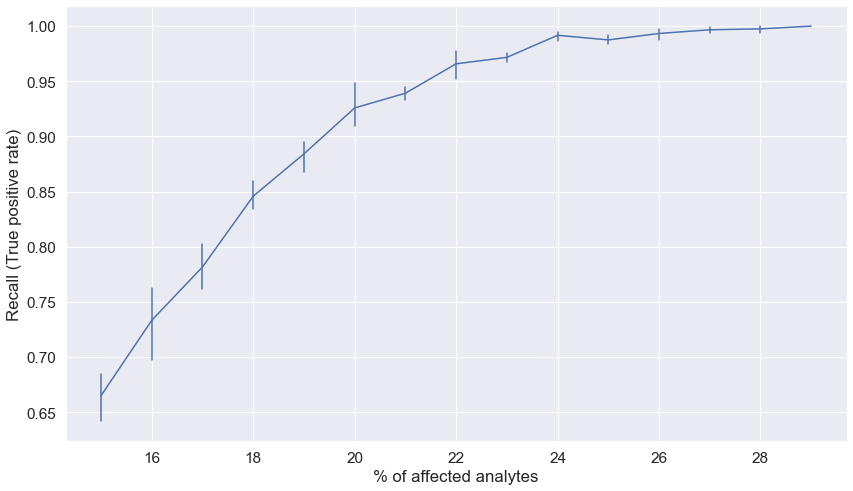

In [24]:
df_res = pd.DataFrame({"Recall":recall, "Num_of_analyte":num_analyte})
# create a column to convert number of analytes to percentages
df_res["Perct"] = df_res["Num_of_analyte"]*100/200

# make a line plot
plt.figure(figsize=(14, 8))
sns.set(font_scale=1.4)
fig = sns.lineplot(data=df_res, x="Perct", y="Recall", err_style="bars")
fig.set_xlabel("% of affected analytes")
fig.set_ylabel("Recall (True positive rate)")

### 5.2 Effects of analyte concentration variability
The variability of analyte concentrations is another influential factor that can affect the detection results. From a statistical perspective, it is expected that affected analytes with lower variability will have a greater impact on the detectability compared to those with higher variability. By considering the variabilities of the analytes, we can gain deeper insights into the contributions of different factors to the detection outcomes.

In [28]:
recall = []
num_analyte = []
vari = []

for num in tqdm(range(30,60,2)):
    
    for i in range(6):

        tngl, tprl = evaluate_model(data_ref, num_samples=(0, 200), num_analyte=num,
                                  analyte_select_method="low", eps=19.6)
        recall.append(tprl)
        num_analyte.append(num)
        vari.append("low")

        tngh, tprh = evaluate_model(data_ref, num_samples=(0, 200), num_analyte=num,
                                  analyte_select_method="high", eps=19.6)
        
        recall.append(tprh)
        num_analyte.append(num)
        vari.append("high")

  0%|          | 0/15 [00:00<?, ?it/s]

Text(0, 0.5, 'Recall (True positive rate)')

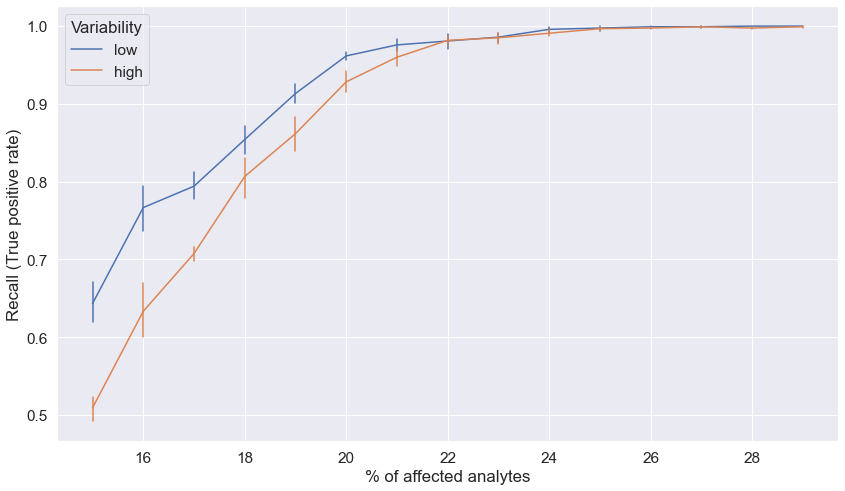

In [29]:
df_res2 = pd.DataFrame({"Recall":recall, "Num_of_analyte":num_analyte, "Variability": vari})
# create a column to convert number of analytes to percentages
df_res2["Perct"] = df_res2["Num_of_analyte"]*100/200

plt.figure(figsize=(14, 8))
sns.set(font_scale=1.4)
fig = sns.lineplot(data=df_res2, x="Perct", y="Recall", hue="Variability", err_style="bars")
fig.set_xlabel("% of affected analytes")
fig.set_ylabel("Recall (True positive rate)")

In this evaluation, similar to the previous one, I altered 30 to 60 out of 200 analytes. However, the analytes were selected based on their concentration variability, specifically high or low variability as indicated by the standard deviation. As anticipated, when considering the same number of affected analytes (less than 22% of the total analytes), analytes with lower variability in concentrations (shown in blue) consistently exhibited higher recall scores compared to those with higher variability (shown in orange). Interestingly, as the number or percentage of affected analytes increased, the recall scores improved and eventually reached a maximum of 1, regardless of the initial variability in analyte concentrations. This observation highlights the increasing effectiveness of the detection model as more analytes are influenced by adulteration, regardless of their initial variability.